In [46]:
# https://github.com/spro/char-rnn.pytorch

import unidecode
import string
import random
import time
import math
import torch


all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [47]:
# https://github.com/spro/char-rnn.pytorch

import torch
import os
import argparse

# from rnn.helpers import *
# from rnn.model import *

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, device=None):
    hidden = decoder.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str).unsqueeze(0).to(device)

    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
      _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
      output, hidden = decoder(inp, hidden)
      
      # Sample from the network as a multinomial distribution

      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]

      # Add predicted character to string and use as next input
      predicted_char = all_characters[top_i]
      predicted += predicted_char
      inp = char_tensor(predicted_char).unsqueeze(0).to(device)

    return predicted


# Generating Text with an RNN

In [48]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# from rnn.model import RNN
# from rnn.helpers import time_since
# from rnn.generate import generate

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [51]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = 'travel.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test

split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 139636
train len:  125672
test len:  13964


In [52]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

hil.'
I was definitely the odd man out.
One thing about my couth upbringing helped me out that
afternoon. I had always been lectured about not talking with
my mouth full. Since Phil and his daughter ke


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [53]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [54]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [55]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [56]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="rnn", n_layers=1):
        super(RNN, self).__init__()

        self.model_type = model_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)
        
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden):

        embedded_input = self.embedding(input)

        if self.model_type == "rnn":
          output, hidden = self.rnn(embedded_input.view(self.n_layers,input.size(0),-1), hidden)
        elif self.model_type == "lstm":
          output, hidden = self.lstm(embedded_input.view(self.n_layers,input.size(0),-1), hidden)
        elif self.model_type == "gru":
          output, hidden = self.gru(embedded_input.view(self.n_layers,input.size(0),-1), hidden)

        output = self.linear(output)

        return output, hidden

    def init_hidden(self, batch_size, device=None):
      
        if self.model_type == "lstm":
            hidden=(torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))
        else:
          hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)

        return hidden


# Train RNN

In [57]:
def train(rnn, input, target, optimizer, criterion):
  
  stringlength,batch_size,loss  = input.size(1),input.size(0),0
  hidden = rnn.init_hidden(batch_size,device)
  
  rnn.zero_grad()

  for i in range(stringlength):
    output, hidden = rnn(input[:, i], hidden)

    loss += criterion(output.view(batch_size, -1), target[:,i])

  loss.backward()
  optimizer.step()
  sigma_loss = loss.item()
  average_loss = sigma_loss/batch_size

  return  average_loss


def eval_test(rnn, inp, target,criterion,batch_size=100):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def complete(batch_size=100,n_epochs=1500,hidden_size = 100,n_layers = 1,learning_rate = 0.01,model_type = 'rnn',print_every = 100,plot_every = 100):

  model = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

  rnn_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  start = time.time()
  all_losses = []
  test_losses = []
  loss_avg = 0
  test_loss_avg = 0

  print("Training for %d epochs..." % n_epochs)
  for epoch in range(1, n_epochs + 1):
      loss = train(model, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
      loss_avg += loss
      
      test_loss = eval_test(model, *load_random_batch(test_text, chunk_len, batch_size),criterion)
      test_loss_avg += test_loss

      if epoch % print_every == 0:
          print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
          print(generate(model, 'Wh', 100, device=device), '\n')

      if epoch % plot_every == 0:
          print(epoch)
          all_losses.append(loss_avg / plot_every)
          test_losses.append(test_loss_avg / plot_every)
          loss_avg = 0
          test_loss_avg = 0
  
  plt.figure()
  plt.plot(all_losses)
  plt.plot(test_losses, color='r')

  generated_text = evaluate(model, prime_str='Th', predict_len=1000)

  print("text generation for model type",model_type,"   ",generated_text)

  return model

Training for 1500 epochs...
 29s (100 6%) train loss: 3.8715, test_loss: 1.8586]
Wher, Shan, 'the said. The his to me?'
Rnot and be am guid alle I said, chill! Hes
ensterion agoled mi 

100
 59s (200 13%) train loss: 3.5557, test_loss: 1.7350]
Whell getider,' I had lost a cortic
sir Plion fines and he was name. 'I leat be didn't it and really n 

200
 29s (300 20%) train loss: 3.3360, test_loss: 1.7298]
Whole of
Cavilied to like you he was the
rurard, which on when you're refers way
oncely not our was pr 

300
 59s (400 26%) train loss: 3.3182, test_loss: 1.6754]
What night with mance visting pilled.
'Conchimment to my why slachore even home and we asked, but beca 

400
 29s (500 33%) train loss: 3.1733, test_loss: 1.6870]
When now this
and '63
Epch some namentation his potle, she
call what I for sitting things, Oliver, loo 

500
 58s (600 40%) train loss: 3.2120, test_loss: 1.6824]
What this comil uppen the ran to mell.'
'Don't you sonovare of the chithe I did to go repiridn't this. 


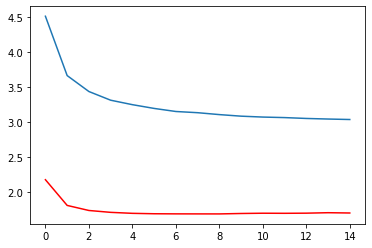

In [59]:
rnn1 = complete(model_type='rnn',hidden_size = 100,n_layers=1)

Training for 1500 epochs...
 30s (100 6%) train loss: 3.5791, test_loss: 1.8039]
Whe scainfoly the I caswatay out a but I cranted collany like about this? I clastering.
'Jech I gother 

100
 0s (200 13%) train loss: 3.2334, test_loss: 1.6851]
Whoos?'
Yes, Father. He wondernary going her what that Jenny was he gone exprating. This it was cave.  

200
 30s (300 20%) train loss: 3.0883, test_loss: 1.6342]
Where was gradually sear gotted how she asok words one sode to the
sided to
stunder:
'For a should has 

300
 1s (400 26%) train loss: 2.9072, test_loss: 1.6336]
Whor!'
'At aid Oliver Landamn of Oliver Barrett!'
She was as Would
here gone, she had not man you expl 

400
 31s (500 33%) train loss: 2.9354, test_loss: 1.6528]
Where this off I sing. She was
araked on the confer so whicked.
'What?'
'For a matk aitolly comment -  

500
 1s (600 40%) train loss: 2.8540, test_loss: 1.6593]
Which care very beive-prestant if the fans for my remperedsenty the now over this for me, silented bee 

60

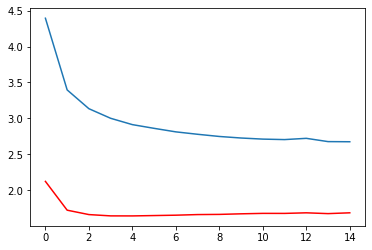

In [60]:
gru1 = complete(model_type='gru',hidden_size = 100,n_layers=1)

Training for 1500 epochs...
 30s (100 6%) train loss: 3.8221, test_loss: 1.8625]
Whiess, dyou guage, all droith heather tur bound trouce.
'A saling no
to there kay none would. Jenny g 

100
 1s (200 13%) train loss: 3.3898, test_loss: 1.7056]
What was hung,' I gong forthy nevers.
Son't this a guess was siring at deancious af in the had it what 

200
 31s (300 20%) train loss: 3.1653, test_loss: 1.6298]
Who makit. At the prestices that purt I was some to relieve sit.
I had bee outt Mr. Cavillered a being 

300
 2s (400 26%) train loss: 3.0208, test_loss: 1.6544]
What be
well, I had syout to Attery to sayses as Jenny had not be cirty than in any, into the more my  

400
 32s (500 33%) train loss: 2.9150, test_loss: 1.6402]
When I termered to her soft that would eye she study.
'Listle-iently.
'Would you thing? What do you pa 

500
 3s (600 40%) train loss: 2.9112, test_loss: 1.6183]
Whough - the
same despitely school.
'Oh - won
this plays off were this and the converthed more, I gues 

60

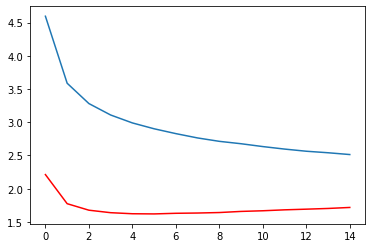

In [61]:
lstm1 = complete(model_type='lstm',hidden_size = 100,n_layers=1)

In [65]:
print(evaluate(rnn1, prime_str='Th', predict_len=1000))

This of me for
mading the Cornell things, scarver in them, Jenny's give been musion. I wanted should shumbuch of the tole so I like a collegh, and I was has a moral, the loves: 'Bade hell.'
The rellied earise conly one at increcimome.'
She father. I mean, after 'oke all which dradus I said he some didn't you could
to get there will, he I wanted it was can belish the so anr.'
'Get the really like Harvard soon and he was and not of the Corpho to heause were acriston, and Stration. Much. Sid.
'Ares, Oliver, I do you lon, Rhode I explly and some
child. Somewh and yet treme' he was
that proot off'
'Yeah, Oliver, it had no love you
less, Jenny and I had every was one, ward, block out to the next
be stamps and years had why did exaing and the vicint,' I said.
'You'll going seat, I resiase come of my name
of to then she was, and so with the doing.'
Prew many took that my stold the moralsy time.'
'That's said her courses all.
'But in the morally
somewlately dished as adopoust
was smile I not re

In [66]:
print(evaluate(gru1, prime_str='Th', predict_len=1000))


The man (I said you talking her that I was so I donent of love held me to me acreated to made her such and down quiet. But if I had he
sixty stood var?'
'No. But I was a took you comply like intedragnally mintion how, which was away. Whrite younced think the boy doended her name) 'ad your profeated, 'A meanino?'
'Because I had told obving I after after the crong were riken three in the goddamn for more nose conversated she assiasmant - we carefuld boautean to hok set a best down the pretty merred.
It don't yes, beif exiser saliation. But I was so watching very preevanty withon one upsember after
the laughe, Dean Thomer, be une-out to pasbie things of up aware, so is not marry in the piece. As out the
place, 'What in the domboxing like so for you to suggest of me, some crebid that look was. 'Doess was dard, rights, but '
Sups. I doingriest I amone to could I scrucking postable. Not my put a goone sake could been name of the spection at my hear-meating
stater, being with his for my iderr

In [67]:
print(evaluate(lstm1, prime_str='Th', predict_len=1000))


The moment worknes of either out of every go cooking oft of the and selthters, who roesn't merely she week lice.
'Yes, sir,' I said.
'Can or every had some playing in a sarally say no cruse'
introde New Yorked as a good never love of the cheek it was late care
of us sharvardamment up a
sates that his all of Jenny, hopain we love you never should the sonto bectia the witty reperstrain the time to take consturet-scone.
'May had to tell that he could not at many talk in the
ring marree. I was love, she was making that! He would love to
smenting it was a delated, Harvard yess too come rich, hopis
of the echol's
quietly, knowing the becauzessed me even I pasture voice, her, whisperate was hear the stake way. Don't so go to marry and fan the roith a doesn't to a sland on the Exet, she said he had
straight was in the ring to her could I love if I waso there pounds the
soker.
'I think it needed as strained him of the trattenstened to marry to get over the and I don't you're your drivically nam

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.